In [1]:
%matplotlib inline


# GHI to POA Transposition

Example of generating clearsky GHI and POA irradiance.


This example shows how to use the
:py:meth:`pvlib.location.Location.get_clearsky` method to generate clearsky
GHI data as well as how to use the
:py:meth:`pvlib.irradiance.get_total_irradiance` function to transpose
GHI data to Plane of Array (POA) irradiance.



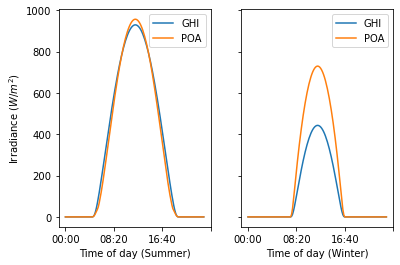

In [2]:
from pvlib import location
from pvlib import irradiance
import pandas as pd
from matplotlib import pyplot as plt

# For this example, we will be using Golden, Colorado
tz = 'MST'
lat, lon = 39.755, -105.221

# Create location object to store lat, lon, timezone
site = location.Location(lat, lon, tz=tz)


# Calculate clear-sky GHI and transpose to plane of array
# Define a function so that we can re-use the sequence of operations with
# different locations
def get_irradiance(site_location, date, tilt, surface_azimuth):
    # Creates one day's worth of 10 min intervals
    times = pd.date_range(date, freq='10min', periods=6*24,
                          tz=site_location.tz)
    # Generate clearsky data using the Ineichen model, which is the default
    # The get_clearsky method returns a dataframe with values for GHI, DNI,
    # and DHI
    clearsky = site_location.get_clearsky(times)
    # Get solar azimuth and zenith to pass to the transposition function
    solar_position = site_location.get_solarposition(times=times)
    # Use the get_total_irradiance function to transpose the GHI to POA
    POA_irradiance = irradiance.get_total_irradiance(
        surface_tilt=tilt,
        surface_azimuth=surface_azimuth,
        dni=clearsky['dni'],
        ghi=clearsky['ghi'],
        dhi=clearsky['dhi'],
        solar_zenith=solar_position['apparent_zenith'],
        solar_azimuth=solar_position['azimuth'])
    # Return DataFrame with only GHI and POA
    return pd.DataFrame({'GHI': clearsky['ghi'],
                         'POA': POA_irradiance['poa_global']})


# Get irradiance data for summer and winter solstice, assuming 25 degree tilt
# and a south facing array
summer_irradiance = get_irradiance(site, '06-20-2020', 25, 180)
winter_irradiance = get_irradiance(site, '12-21-2020', 25, 180)

# Convert Dataframe Indexes to Hour:Minute format to make plotting easier
summer_irradiance.index = summer_irradiance.index.strftime("%H:%M")
winter_irradiance.index = winter_irradiance.index.strftime("%H:%M")

# Plot GHI vs. POA for winter and summer
fig, (ax1, ax2) = plt.subplots(1, 2, sharey=True)
summer_irradiance['GHI'].plot(ax=ax1, label='GHI')
summer_irradiance['POA'].plot(ax=ax1, label='POA')
winter_irradiance['GHI'].plot(ax=ax2, label='GHI')
winter_irradiance['POA'].plot(ax=ax2, label='POA')
ax1.set_xlabel('Time of day (Summer)')
ax2.set_xlabel('Time of day (Winter)')
ax1.set_ylabel('Irradiance ($W/m^2$)')
ax1.legend()
ax2.legend()
plt.show()

Note that in Summer, there is not much gain when comparing POA irradiance to
GHI. In the winter, however, POA irradiance is significantly higher than
GHI. This is because, in winter, the sun is much lower in the sky, so a
tilted array will be at a more optimal angle compared to a flat array.
In summer, the sun gets much higher in the sky, and there is very little
gain for a tilted array compared to a flat array.

